# Exploring Structure in Chinese Noun Embeddings

---

This project investigates how Chinese nouns organise in BERT’s embedding space, using clustering and dimensionality reduction to uncover underlying linguistic patterns. 

The goal was to explore whether semantic categories emerge naturally from contextual embeddings, and to what extent structural properties of Chinese, such as single-character morphology, influence the organisation of meaning.  

---

This notebook uses pre-computed clustering results exported from [**noun_clustering.ipynb**](noun_clustering.ipynb). The clustering file is not tracked in git but can be regenerated by running the other notebook.

## Plot

In [2]:
''' 
Note: This code was generated with AI assistance to enable rapid prototyping
'''

# ============================================================================
# ADJUSTABLE PARAMETERS
# ============================================================================
top_n_words_per_cluster = 10  # How many words to show per cluster
word_size_min = 3              # Minimum word marker size
word_size_max = 6             # Maximum word marker size
sphere_size_base = 40          # Base sphere size multiplier
label_offset_z = 0.4           # How far above sphere to place label
word_distance_scale = 0.3      # Scale factor for word distance from centroid (0.5 = half distance)

# ============================================================================

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from pypinyin import lazy_pinyin, Style
import pickle

# Load the pre-computed clustering from noun_clustering.ipynb
with open('data/noun_clustering_1000_28.pkl', 'rb') as f:
    clustering_data = pickle.load(f)

# Extract the saved data
cluster_labels = clustering_data['cluster_labels']
embeddings_pca100 = clustering_data['embeddings_pca100']
n_clusters = clustering_data['n_clusters']
nouns_top1000 = clustering_data['nouns_df']

# Create a list of outliers to exclude
words_to_exclude = ['引擎', '晚餐', '夫妇', '妈', '地球', '哥']

# Get indices of words to keep
mask_to_keep = ~nouns_top1000['Noun'].isin(words_to_exclude)
indices_to_keep = mask_to_keep.values

# Filter the data
nouns_top1000 = nouns_top1000[mask_to_keep].reset_index(drop=True)
embeddings_pca100 = embeddings_pca100[indices_to_keep]
cluster_labels = cluster_labels[indices_to_keep]

# Add pinyin column if it doesn't exist
if 'Pinyin' not in nouns_top1000.columns:
    nouns_top1000['Pinyin'] = nouns_top1000['Noun'].apply(
        lambda x: ' '.join(lazy_pinyin(x, style=Style.TONE))
    )

# Reduce to 3D for visualization
pca_3d = PCA(n_components=3, random_state=42)
embeddings_3d = pca_3d.fit_transform(embeddings_pca100)

# Semantic labels for clusters
cluster_labels_semantic = {
    2: "Places",
    8: "Body Parts",
    9: "Food",
    19: "Vehicles",
    22: "Family Members",
    23: "Animals",
    15: "Single Characters",
}

# Only display clusters that have semantic labels
display_clusters = np.array(list(cluster_labels_semantic.keys()))

# Color map for clusters
color_map = {
    2: '#06B6D4',  # Cyan (Places)
    8: '#EF4444',   # Red (Body Parts)
    9: '#F59E0B',   # Amber (Food)
    19: '#10B981',  # Green (Vehicles)
    22: '#EC4899',  # Pink (Family Members)
    23: '#F97316',  # Orange (Animals)
    15: '#FFFFFF',  # White (Single Characters)
}

# Calculate cluster info and collect all top words
cluster_info = []
all_top_words_data = []

for cluster_id in display_clusters:
    cluster_mask = cluster_labels == cluster_id
    cluster_points_3d = embeddings_3d[cluster_mask]
    cluster_points_pca100 = embeddings_pca100[cluster_mask]
    cluster_words = nouns_top1000[cluster_mask].copy()
    
    if len(cluster_points_3d) == 0:
        continue
    
    # Calculate centroid in both spaces
    centroid_3d = cluster_points_3d.mean(axis=0)
    centroid_pca100 = cluster_points_pca100.mean(axis=0)
    
    # Calculate distances from centroid in 100D space
    distances_100d = np.linalg.norm(cluster_points_pca100 - centroid_pca100, axis=1)
    
    # Get top N words CLOSEST TO CENTROID
    closest_indices = np.argsort(distances_100d)[:top_n_words_per_cluster]
    
    # Calculate average distance for ONLY the top 10 displayed words
    avg_distance_top10 = distances_100d[closest_indices].mean()
    
    cluster_words_with_index = cluster_words.reset_index(drop=True)
    
    for local_idx in closest_indices:
        word_row = cluster_words_with_index.iloc[local_idx]
        
        all_top_words_data.append({
            'cluster_id': cluster_id,
            'noun': word_row['Noun'],
            'english': word_row['English'],
            'pinyin': word_row['Pinyin'],
            'frequency': word_row['Frequency'],
            'position_3d': cluster_points_3d[local_idx],
            'centroid_3d': centroid_3d,
            'color': color_map[cluster_id]
        })
    
    cluster_info.append({
        'id': cluster_id,
        'centroid': centroid_3d,
        'size': cluster_mask.sum(),
        'avg_spread': avg_distance_top10,
        'label': cluster_labels_semantic[cluster_id],
        'color': color_map[cluster_id]
    })

# Group words by cluster for per-cluster frequency scaling
words_by_cluster = {}
for word_data in all_top_words_data:
    cluster_id = word_data['cluster_id']
    if cluster_id not in words_by_cluster:
        words_by_cluster[cluster_id] = []
    words_by_cluster[cluster_id].append(word_data)

# Calculate frequency range for each cluster
cluster_freq_ranges = {}
for cluster_id, words in words_by_cluster.items():
    freqs = [w['frequency'] for w in words]
    min_freq = min(freqs)
    max_freq = max(freqs)
    cluster_freq_ranges[cluster_id] = {
        'min': min_freq,
        'max': max_freq,
        'range': max_freq - min_freq if max_freq > min_freq else 1
    }

# Calculate spread range across ALL clusters for sphere sizing
all_spreads = [c['avg_spread'] for c in cluster_info]
min_spread = min(all_spreads)
max_spread = max(all_spreads)
spread_range = max_spread - min_spread if max_spread > min_spread else 1

# Create figure
fig = go.Figure()

# Add spheres for each cluster (sized by spread)
for info in cluster_info:
    centroid = info['centroid']
    
    # Scale sphere size based on cluster spread
    normalized_spread = (info['avg_spread'] - min_spread) / spread_range
    sphere_size = sphere_size_base * (0.5 + normalized_spread * 1.0)
    
    # Add sphere
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        name=info['label'],
        marker=dict(
            size=sphere_size,
            color=info['color'],
            line=dict(width=2, color='white'),
            opacity=0.3
        ),
        hovertemplate=(
            f"<b>{info['label']}</b><br>"
            f"Size: {info['size']} words<br>"
            f"Spread: {info['avg_spread']:.3f}<br>"
            "<extra></extra>"
        ),
        showlegend=True,
        legendgroup=str(info['id'])
    ))
    
    # Add cluster label above sphere
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2] + label_offset_z],
        mode='text',
        text=[info['label']],
        textfont=dict(size=14, color='white', family='Arial Black'),
        textposition='middle center',
        showlegend=False,
        hoverinfo='skip',
        legendgroup=str(info['id'])
    ))

# Add top words as sized points (with per-cluster frequency scaling)
for word_data in all_top_words_data:
    cluster_id = word_data['cluster_id']
    freq_info = cluster_freq_ranges[cluster_id]
    
    # Scale word size based on frequency WITHIN THIS CLUSTER
    normalized_freq = (word_data['frequency'] - freq_info['min']) / freq_info['range']
    word_size = word_size_min + (word_size_max - word_size_min) * normalized_freq
    
    pos = word_data['position_3d']
    centroid = word_data['centroid_3d']
    
    # Scale distance from centroid
    direction = pos - centroid
    scaled_pos = centroid + direction * word_distance_scale
    
    fig.add_trace(go.Scatter3d(
        x=[scaled_pos[0]],
        y=[scaled_pos[1]],
        z=[scaled_pos[2]],
        mode='markers',
        marker=dict(
            size=word_size,
            color=word_data['color'],
            line=dict(width=1, color='white'),
            opacity=0.9
        ),
        hovertemplate=(
            f"<b>{word_data['noun']}</b> <b>({word_data['pinyin']})</b><br>"
            f"{word_data['english']}<br>"
            "<extra></extra>"
        ),
        showlegend=False,
        legendgroup=str(word_data['cluster_id'])
    ))

# Configure layout
fig.update_layout(
    title={
        'text': '<b>BERT Embedding Structure of Top 1000 Chinese Nouns</b><br>Agglomerative Clustering - 100 Principal Components',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16, 'color': 'white'}
    },
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(
            backgroundcolor='#1E1E1E',
            gridcolor='#404040',
            showbackground=True,
            zerolinecolor='#404040',
            title=dict(font=dict(color='white'))
        ),
        yaxis=dict(
            backgroundcolor='#1E1E1E',
            gridcolor='#404040',
            showbackground=True,
            zerolinecolor='#404040',
            title=dict(font=dict(color='white'))
        ),
        zaxis=dict(
            backgroundcolor='#1E1E1E',
            gridcolor='#404040',
            showbackground=True,
            zerolinecolor='#404040',
            title=dict(font=dict(color='white'))
        ),
        camera=dict(
            eye=dict(x=2.5, y=2.5, z=2.5)
        ),
        bgcolor='#1E1E1E'
    ),
    width=1600,
    height=1000,
    hoverlabel=dict(
        bgcolor="rgba(30,30,30,0.95)",
        font_size=12,
        font_family="Arial",
        font_color="white"
    ),
    paper_bgcolor='#1E1E1E',
    plot_bgcolor='#1E1E1E',
    hovermode='closest',
    showlegend=True,
    legend=dict(
        bgcolor='rgba(30,30,30,0.8)',
        font=dict(color='white', size=10),
        itemsizing='constant'
    )
)

fig.show(renderer='browser')

![top_1000](images/top_1000.png)

This visualisation displays a 3D projection of the 100-dimensional PCA space.

**Note:** Only 7 of the 28 clusters are shown, and word positions are scaled to 30% of their actual distance from cluster centroids to reduce visual clutter whilst preserving relative structure.

---

Single-character nouns form a distinct cluster at low PC1 values, whereas multi-character nouns occupy higher PC1 regions.

Interestingly, all three-character words in the visualisation appear exclusively in the Vehicles cluster, which has the highest PC1 value of all 7 clusters shown.

To quantify this relationship, the following analysis examines the correlation between PC1 and word length.

## Correlation Analysis

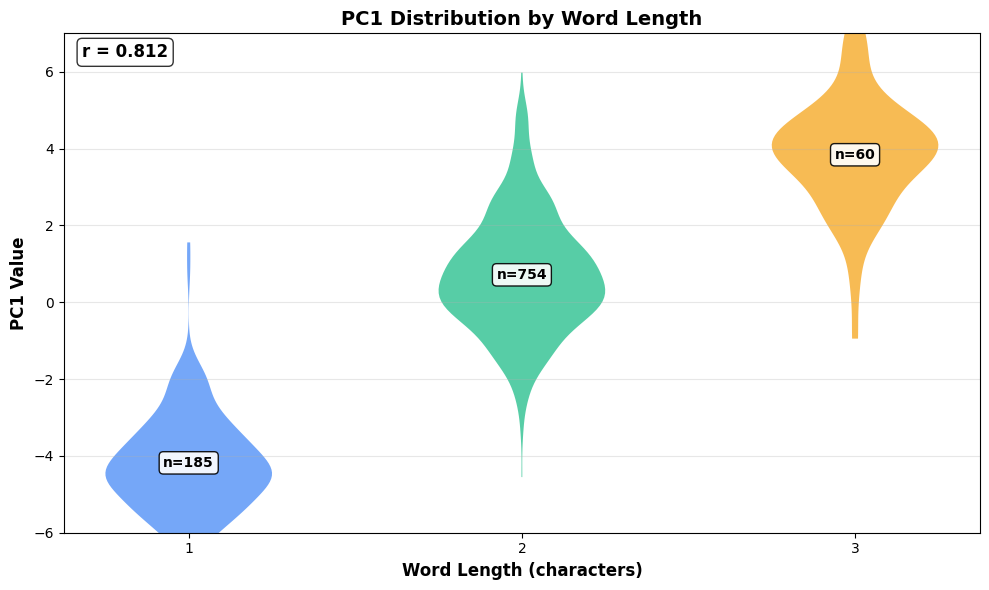

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load the original unfiltered data for correlation analysis
with open('data/noun_clustering_1000_28.pkl', 'rb') as f:
    clustering_data_full = pickle.load(f)

nouns_top1000_full = clustering_data_full['nouns_df']
embeddings_pca100_full = clustering_data_full['embeddings_pca100']

# Reduce to 3D using the FULL dataset
pca_3d_full = PCA(n_components=3, random_state=42)
embeddings_3d_full = pca_3d_full.fit_transform(embeddings_pca100_full)

# Calculate word lengths and PC1 values from FULL dataset
word_lengths = nouns_top1000_full['Noun'].str.len().values
pc1_3d_values = embeddings_3d_full[:, 0]

# Filter out 4-character words
mask = word_lengths != 4
word_lengths = word_lengths[mask]
pc1_3d_values = pc1_3d_values[mask]

# Calculate correlation
correlation, p_value = pearsonr(pc1_3d_values, word_lengths)

# Create DataFrame for easier plotting
df_plot = pd.DataFrame({
    'PC1': pc1_3d_values,
    'Word Length': word_lengths
})

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Violin plot (without any internal lines or whiskers)
lengths = sorted(df_plot['Word Length'].unique())
data_by_length = [df_plot[df_plot['Word Length'] == l]['PC1'].values for l in lengths]

parts = ax.violinplot(data_by_length, positions=lengths, showmeans=False, showmedians=False, 
                       showextrema=False)
ax.set_xlabel('Word Length (characters)', fontsize=12, fontweight='bold')
ax.set_ylabel('PC1 Value', fontsize=12, fontweight='bold')
ax.set_title('PC1 Distribution by Word Length', fontsize=14, fontweight='bold')
ax.set_xticks(lengths)
ax.set_ylim(-6, 7)  # Set y-axis range
ax.grid(True, alpha=0.3, axis='y')

# Color the violins
colors = ['#3B82F6', '#10B981', '#F59E0B']
for pc, color in zip(parts['bodies'], colors[:len(parts['bodies'])]):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Remove whiskers and caps (error range lines)
for partname in ('cbars', 'cmins', 'cmaxes'):
    if partname in parts:
        parts[partname].set_visible(False)

# Add sample size labels at the center (mean) of each violin
for i, length in enumerate(lengths):
    n = len(data_by_length[i])
    mean_val = np.mean(data_by_length[i])
    ax.text(length, mean_val, f'n={n}', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# Add correlation annotation
ax.text(0.02, 0.98, f'r = {correlation:.3f}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

PC1 in the 100-dimensional embedding space (representing the primary axis of variance) is strongly correlated with word length (**r = 0.812**). 

Visualised in 3D, this manifests as a morphological gradient along the PC1 axis. Single-character words cluster distinctly at low values, two-character words at intermediate values, and three-character words at the highest values. 

## Interpretation

**These results reveal that morphological complexity, rather than semantic similarity alone, is the dominant organising principle in how BERT represents Chinese nouns.**

Though single-character nouns exhibit high semantic diversity, they show surprisingly limited variance along other principal components. Two-character nouns, on the other hand, distribute across the full embedding space.

This suggests that morphological form acts as a primary constraint on representation, raising a key question: 

**Do single-character nouns retain semantic organisation within this compressed subspace, or does morphological encoding dominate entirely?**